<a href="https://colab.research.google.com/github/meghavi1610/Group7_STA380_Excercises/blob/main/Question%206%20-%20The%20Reuters%20Corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Reuters corpus
Revisit the Reuters C50 text corpus that we briefly explored in class. Your task is simple: tell an interesting story, anchored in some analytical tools we have learned in this class, using this data. For example:

- you could cluster authors or documents and tell a story about what you find.
- you could look for common factors using PCA.
- you could train a predictive model and assess its accuracy, constructing features for each document that maximize performance.
- you could do anything else that strikes you as interesting with this data.

Describe clearly what question you are trying to answer, what models you are using, how you pre-processed the data, and so forth. Make sure you include at least one really interesting plot (although more than one might be necessary, depending on your question and approach.)

Format your write-up in the following sections, some of which might be quite short:

Question: What question(s) are you trying to answer?
Approach: What approach/statistical tool did you use to answer the questions?
Results: What evidence/results did your approach provide to answer the questions? (E.g. any numbers, tables, figures as appropriate.)
Conclusion: What are your conclusions about your questions? Provide a written interpretation of your results, understandable to stakeholders who might plausibly take an interest in this data set.
Regarding the data itself: In the C50train directory, you have 50 articles from each of 50 different authors (one author per directory). Then in the C50test directory, you have another 50 articles from each of those same 50 authors (again, one author per directory). This train/test split is obviously intended for building predictive models, but to repeat, you need not do that on this problem. You can tell any story you want using any methods you want. Just make it compelling!

Note: if you try to build a predictive model, you will need to figure out a way to deal with words in the test set that you never saw in the training set. This is a nontrivial aspect of the modeling exercise. (E.g. you might simply ignore those new words.)

This question will be graded according to three criteria:

the overall "interesting-ness" of your question and analysis.
the clarity of your description. We will be asking ourselves: could your analysis be reproduced by a competent data scientist based on what you've said? (That's good.) Or would that person have to wade into the code in order to understand what, precisely, you've done? (That's bad.)
technical correctness (i.e. did you make any mistakes in execution or interpretation?)

# Overall Questions:
Here are three questions that our analysis on the Reuters C50 dataset aims to solve:

1. Can we identify and cluster together similar articles based on their content, and what potential patterns are revealed in the data through such clustering?

2. What are the key themes across the different articles in the dataset as uncovered by Latent Dirichlet Allocation (LDA) topic modeling?

3. How accurately can a supervised machine learning model, trained on known information about the authors and their writing styles, predict the authorship of unseen articles?

## Data Unzip

In [ ]:
import zipfile

In [ ]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/ML/reuter+50+50.zip'
unzip_folder_path = '/content/drive/MyDrive/Colab Notebooks/ML/'

In [ ]:
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_folder_path)
    print("Unzipped successfully.")
except zipfile.BadZipFile:
    print("Error: The provided zip file is corrupt.")
except Exception as e:
    print(f"An error occurred: {e}")

Unzipped successfully.


## Clustering

### Question for Clustering:
1. Can we group similar articles together based on their contents to reveal underlying patterns?
2. Are we able to differentiate these clusters?

### Approach for Clustering:

1. Load the raw data of 50 articles by 50 authors in the C50 Train folder

2. Preprocess the text data by removing stop words, punctuation, making all lower case and performing lemmatization to reduce words to their root form.

2. Transform the preprocessed text into vectors using the TF-IDF (Term Frequency-Inverse Document Frequency) method.

3. Determine the optimal number of clusters using evaluation approaches such as Elbow Joint Plot.

4. Use the vectorized text data to create an unsupervised clustering model; potential algorithms to be used include K-means and DBSCAN.

5. Review the centroids of each cluster and evaluate the results both qualitatively (through examining the grouped articles) and quantitatively (using metrics like silhouette scores).

7. Apply dimensionality reduction techniques such as Principal Component Analysis (PCA) to represent the clusters in two dimensions for visualization purposes.

#### Package Imports

In [22]:
!pip install yellowbrick
# !pip install transformers
# !pip install bert-extractive-summarizer
# !pip install sentencepiece

In [27]:
import os
import re
import nltk
import nltk.corpus
import numpy as np
import pandas as pd
from collections import Counter
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

#### Import and Clean Data

In [2]:
# It's necessary to download these nltk packages before processing.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
train_folder = '/content/drive/MyDrive/Colab Notebooks/ML/C50train'

C50Train_corpus = {}
for subfolder in os.listdir(train_folder):
    subfolder_path = os.path.join(train_folder, subfolder)
    if os.path.isdir(subfolder_path):
        file_contents = []
        for filename in os.listdir(subfolder_path):
            if filename.endswith('.txt'):
                file_path = os.path.join(subfolder_path, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    file_contents.append(file.read())
        C50Train_corpus[subfolder] = file_contents

all_articles_train = [article for articles in C50Train_corpus.values() for article in articles]

In [33]:
# Removing the words "said", "could", and "would" separately, as they aren't typically included in common stop words lists. However, they frequently appear in the articles and thus need to be excluded.
words_to_remove = ["said", "could", "would"]
stop_words = set(stopwords.words('english')+words_to_remove)
lemmatizer = WordNetLemmatizer()

def clean_text(article):
    formatted_article = re.sub('[^a-zA-Z]', ' ', article )
    formatted_article = re.sub(r'\s+', ' ', formatted_article)

    word_list = word_tokenize(formatted_article.lower())
    word_list = [word for word in word_list if not word in stop_words]

    word_list = [lemmatizer.lemmatize(word) for word in word_list]

    return ' '.join(word_list)

In [34]:
clean_articles_train = []
for article in all_articles_train:
  clean_article = clean_text(article)
  clean_articles_train.append(clean_article)

In [35]:
print(f'{len(all_articles_train)} - {len(clean_articles_train)}\n\n{all_articles_train[0]}\n{clean_articles_train[0]}')

2500 - 2500

The Internet may be overflowing with new technology but crime in cyberspace is still of the old-fashioned variety.
The National Consumers League said Wednesday that the most popular scam on the Internet was the pyramid scheme, in which early investors in a bogus fund are paid off with deposits of later investors.
The league, a non-profit consumer advocacy group, tracks web scams through a site it set up on the world wide web in February called Internet Fraud Watch at http://www.fraud.org.
The site, which collects reports directly from consumers, has been widely praised by law enforcement agencies.
"Consumers who suspect a scam on the Internet have critical information," said Jodie Bernstein, director of the Federal Trade Commission's Bureau of Consumer Protection. Internet Fraud Watch "has been a major help to the FTC in identifying particular scams in their infancy."
In May, for example, the commission used Internet reports to shut down a site run by Fortuna Alliance that

#### Vectorize

In [36]:
# Word2Vec Vectorizer (Not used since clustering which relies on document-level analysis, TF-IDF is generally better)

# tokenized_articles = [nltk.word_tokenize(article) for article in clean_articles_train]

# model = Word2Vec(tokenized_articles, min_count=2)
# X = model.wv.vectors

# print(model.wv['article'][:5])

# similar_words = model.wv.most_similar('news', topn=10)
# print(similar_words)

In [37]:
# TFIDF Vectorizer
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,1),
    max_features=500
)
X = vectorizer.fit_transform(clean_articles_train).toarray()

In [38]:
clean_articles_train[0]

'internet may overflowing new technology crime cyberspace still old fashioned variety national consumer league wednesday popular scam internet pyramid scheme early investor bogus fund paid deposit later investor league non profit consumer advocacy group track web scam site set world wide web february called internet fraud watch http www fraud org site collect report directly consumer widely praised law enforcement agency consumer suspect scam internet critical information jodie bernstein director federal trade commission bureau consumer protection internet fraud watch major help ftc identifying particular scam infancy may example commission used internet report shut site run fortuna alliance taken million promising investor earn month initial deposit instead fortuna kept money commission charged fraud report league site visited time forwarded local state federal authority second popular internet scam league sale bogus internet service custom designed web site internet access account th

In [39]:
X

array([[0.        , 0.06887977, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0624473 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.49308212, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.07557698, ..., 0.09020942, 0.        ,
        0.        ],
       [0.12656093, 0.        , 0.06036828, ..., 0.24018719, 0.        ,
        0.        ],
       [0.        , 0.06567418, 0.        , ..., 0.13575453, 0.        ,
        0.        ]])

In [40]:
X.shape

(2500, 500)

#### K Means Elbow Test

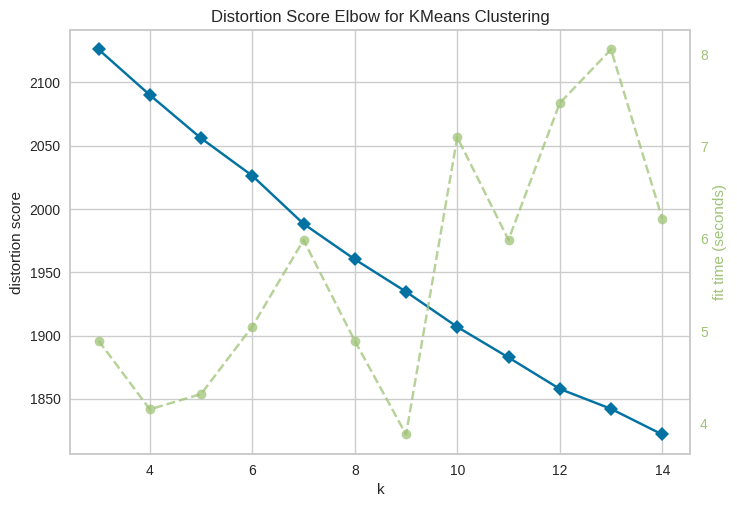


Best K value: None


In [41]:
model = KMeans(n_init=10, random_state=42)
visualizer = KElbowVisualizer(model, k=(3, 15), locate_elbow=False)
visualizer.fit(X)
visualizer.show()

best_k = visualizer.elbow_value_
print(f"\nBest K value: {best_k}")

In [42]:
# Using the KElbowVisualizer directly for convenience

# wcss = []
# max_clusters = 10
# steps = 1

# for k in range(1, max_clusters, steps):
#     kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
#     kmeans.fit(X)
#     wcss.append(kmeans.inertia_)

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, max_clusters, steps), wcss, marker='o')
# plt.title('Elbow Method for Optimal K')
# plt.xlabel('K')
# plt.ylabel('WCSS')
# plt.show()

#### Clustering by K-Means

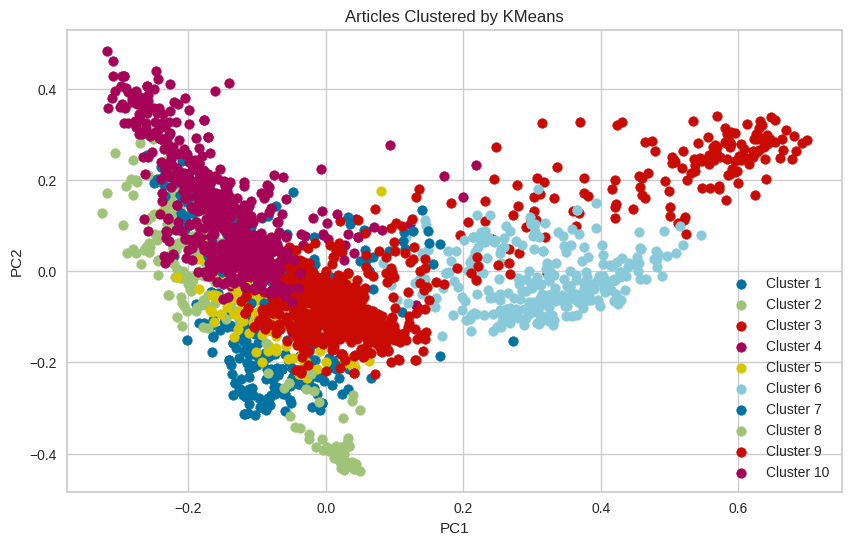

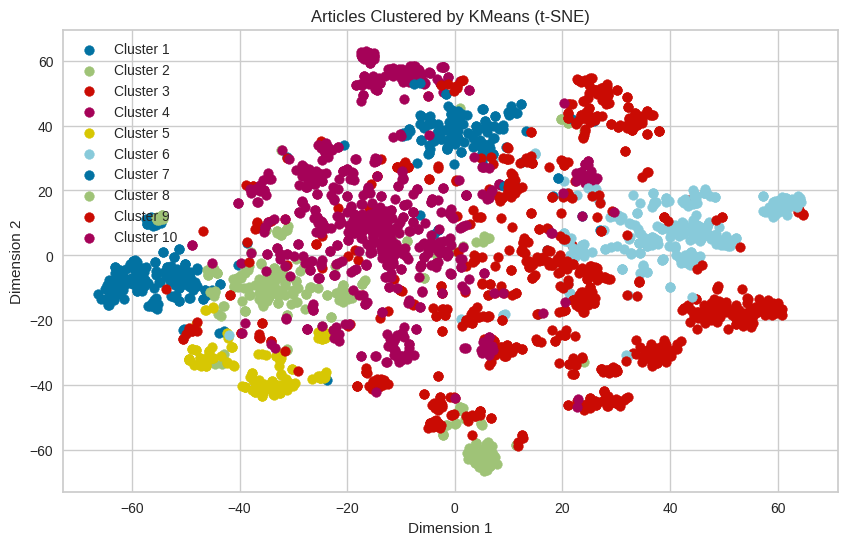

In [44]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Choosing 10 clusters for interpretability
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 2D PCA Plot
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    plt.scatter(X_pca[cluster_indices, 0], X_pca[cluster_indices, 1], label=f'Cluster {i + 1}')
plt.title('Articles Clustered by KMeans')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# 2D t-SNE Plot
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices, 1], label=f'Cluster {i + 1}')
plt.title('Articles Clustered by KMeans (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [45]:
from sklearn import metrics

pred_labels = kmeans.labels_

dbi = metrics.davies_bouldin_score(X, pred_labels)
ss = metrics.silhouette_score(X, pred_labels , metric='euclidean')

print("DBI Score: ", dbi, "\nSilhoutte Score: ", ss)

DBI Score:  3.820271085035145 
Silhoutte Score:  0.05724761847669141


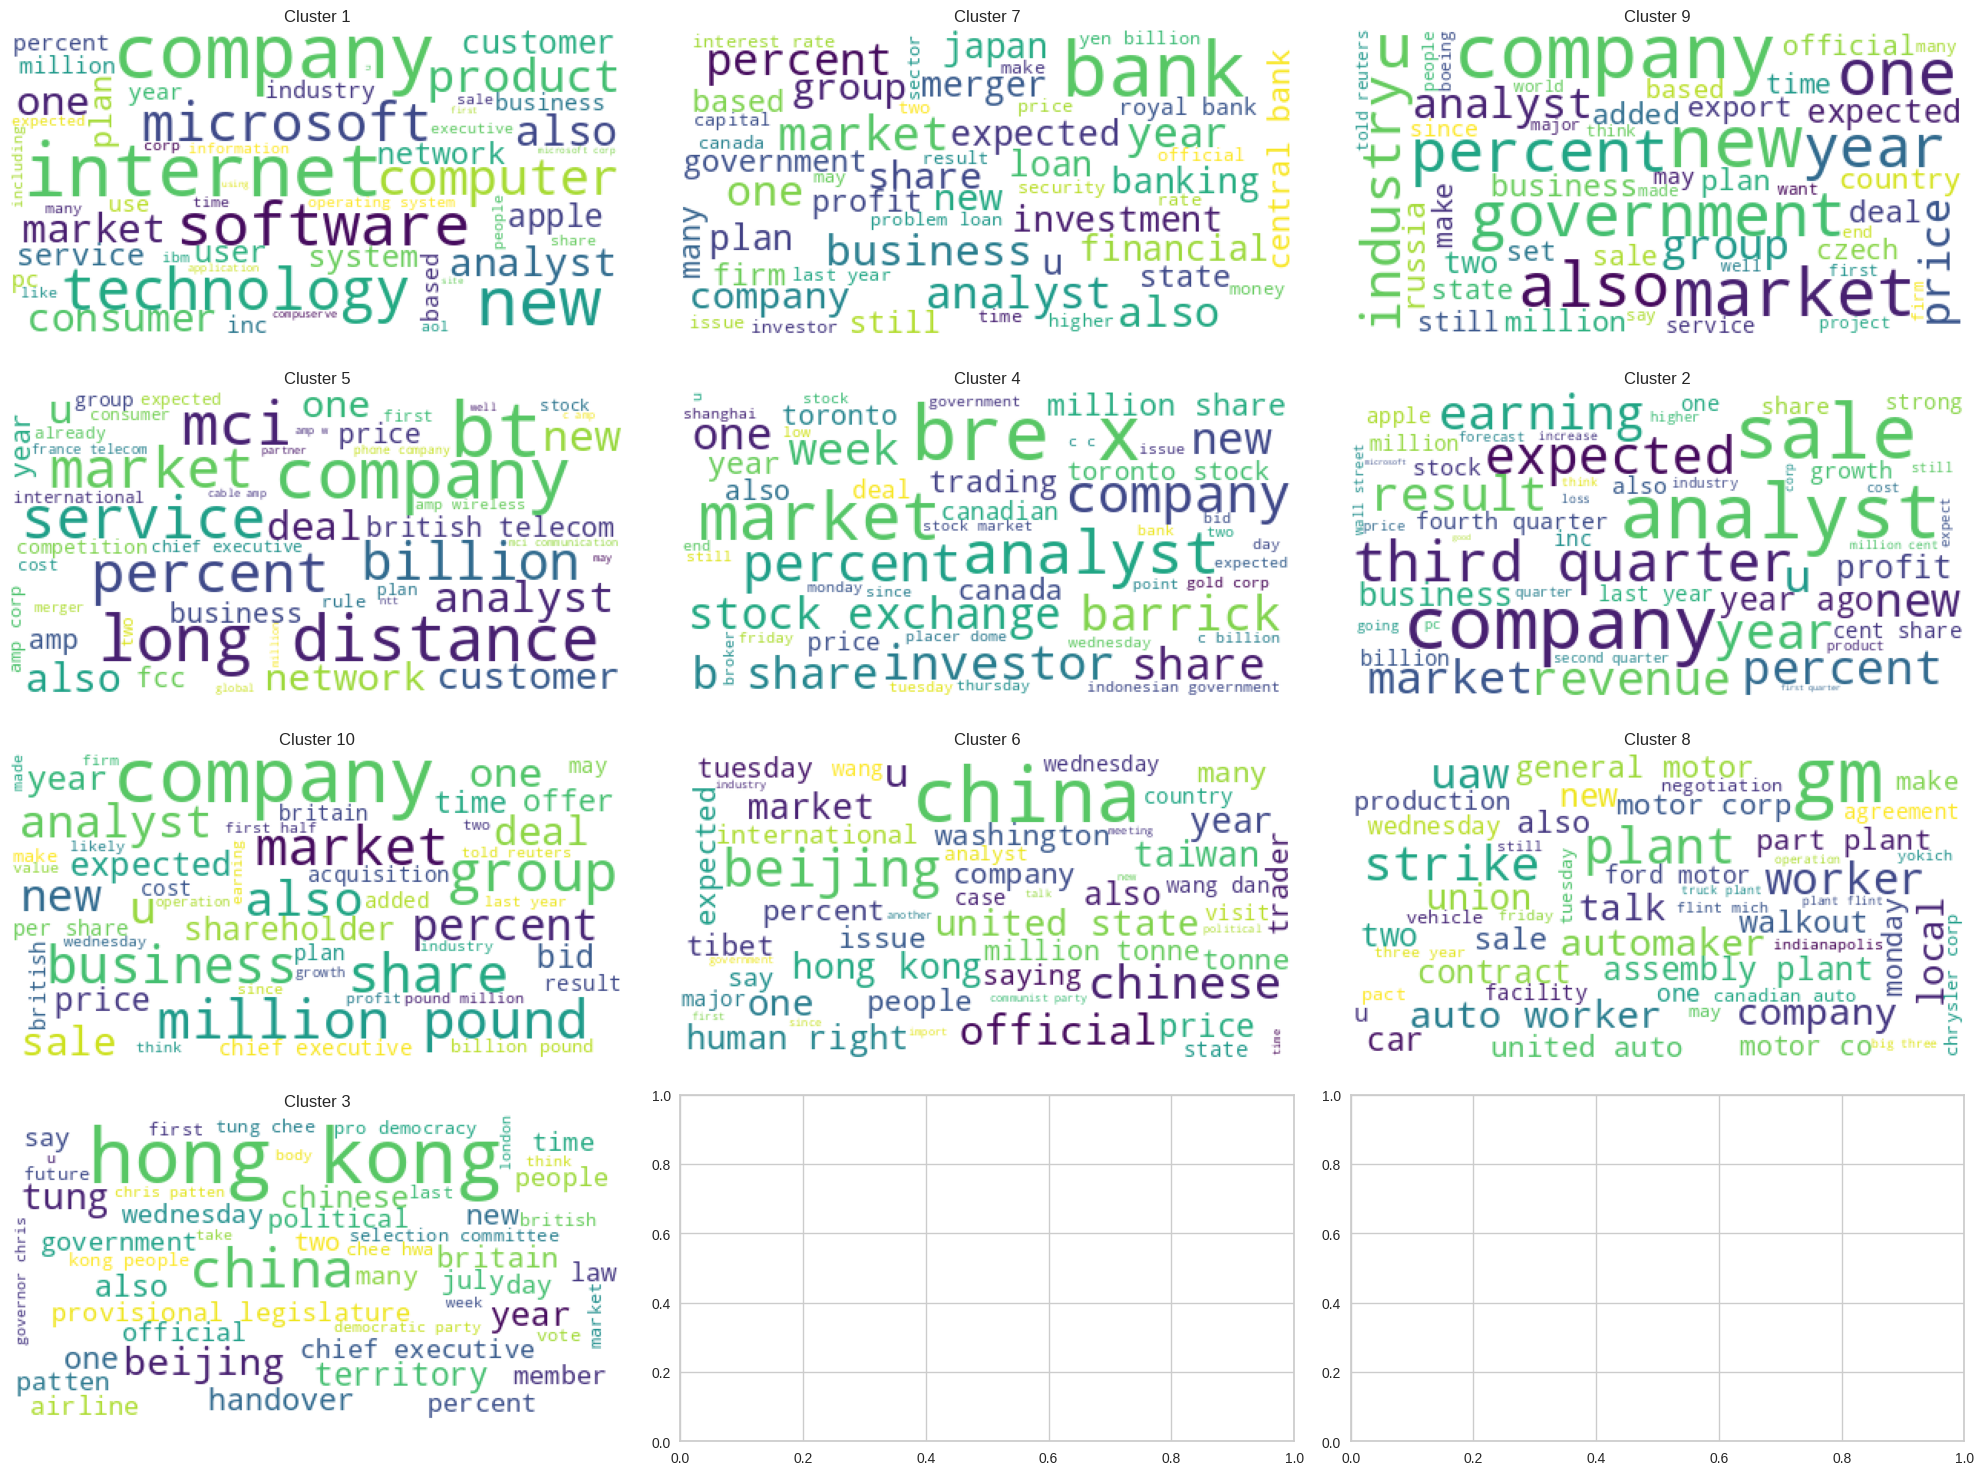

In [46]:
from wordcloud import WordCloud
import math

# This will contain all articles per cluster
articles_per_cluster = {label: '' for label in cluster_labels}

# Collect all articles per cluster into our new dictionary
for label, article in zip(cluster_labels, clean_articles_train):
    articles_per_cluster[label] += ' ' + article

cols = 3
rows = math.ceil(num_clusters / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20,15))

for i, (cluster, text) in enumerate(articles_per_cluster.items()):
    wordcloud = WordCloud(
        background_color ='white',
        stopwords = stopwords.words('english'),
        max_words=50,
        max_font_size=50,
        random_state=42
    ).generate(text)

    axs[i//cols, i%cols].imshow(wordcloud)
    axs[i//cols, i%cols].axis("off")
    axs[i//cols, i%cols].set_title(f'Cluster {cluster + 1}')

plt.tight_layout()
plt.show()

In [48]:
articles_per_cluster = {label: '' for label in cluster_labels}

for label, article in zip(cluster_labels, clean_articles_train):
    articles_per_cluster[label] += ' ' + article

sorted_items = sorted(articles_per_cluster.items())

for cluster, text in sorted_items:
    words = word_tokenize(text)
    common_words = Counter(words).most_common(5)  # get 10 most common words
    print(f'Cluster {cluster + 1} common words: {common_words}')

Cluster 1 common words: [('internet', 757), ('computer', 664), ('company', 632), ('software', 483), ('new', 479)]
Cluster 2 common words: [('quarter', 1118), ('year', 909), ('analyst', 839), ('percent', 826), ('sale', 778)]
Cluster 3 common words: [('hong', 1460), ('kong', 1450), ('china', 829), ('year', 384), ('tung', 348)]
Cluster 4 common words: [('gold', 617), ('share', 554), ('stock', 481), ('market', 459), ('x', 385)]
Cluster 5 common words: [('company', 574), ('amp', 569), ('mci', 560), ('market', 540), ('bt', 462)]
Cluster 6 common words: [('china', 1933), ('chinese', 952), ('year', 890), ('beijing', 875), ('u', 850)]
Cluster 7 common words: [('bank', 1920), ('year', 506), ('banking', 360), ('analyst', 358), ('percent', 339)]
Cluster 8 common words: [('gm', 741), ('plant', 534), ('worker', 396), ('uaw', 290), ('strike', 260)]
Cluster 9 common words: [('year', 1625), ('percent', 1292), ('company', 1234), ('market', 1014), ('new', 967)]
Cluster 10 common words: [('million', 2204)

#### Clustering by DBSCAN

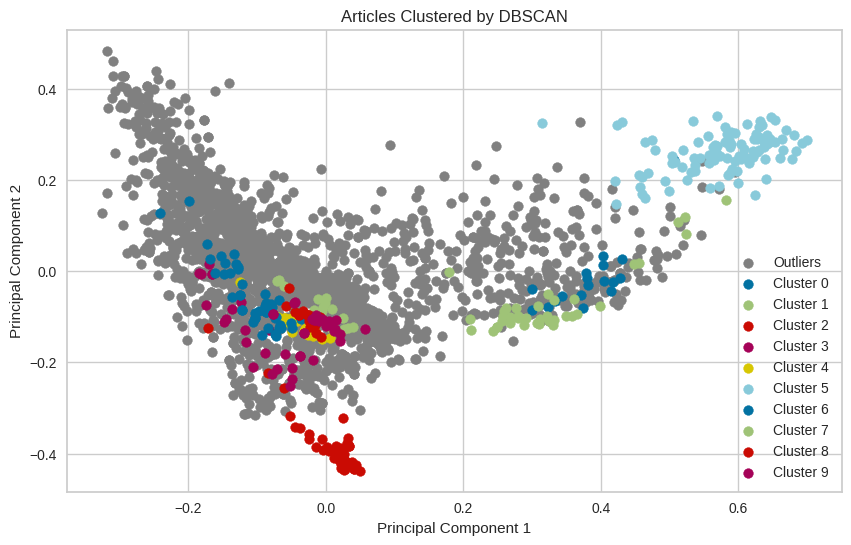

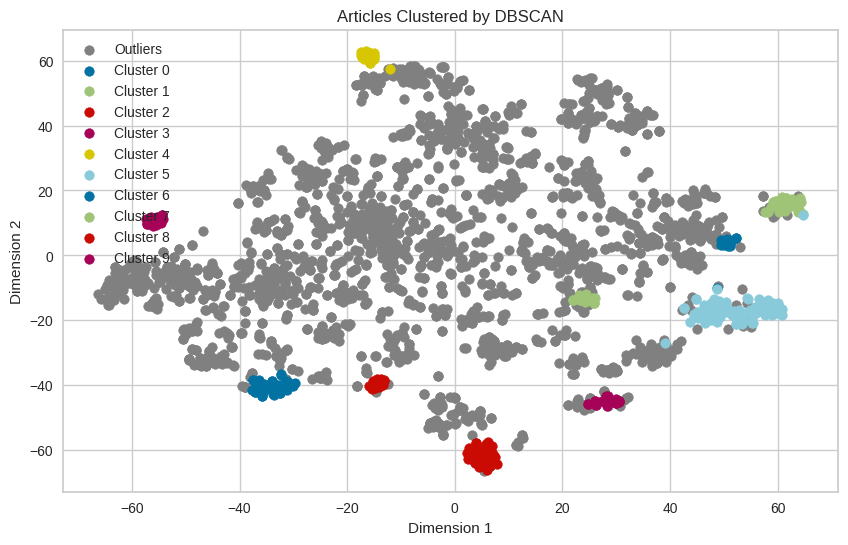

In [49]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

dbscan = DBSCAN(eps=0.77, min_samples=18)
cluster_labels = dbscan.fit_predict(X)

# 2D PCA Plot
plt.figure(figsize=(10, 6))
unique_labels = np.unique(cluster_labels)
for label in unique_labels:
    if label == -1:
        # Outliers (noise points) are labeled as -1
        plt.scatter(X_pca[cluster_labels == label, 0], X_pca[cluster_labels == label, 1], color='gray', label='Outliers')
    else:
        plt.scatter(X_pca[cluster_labels == label, 0], X_pca[cluster_labels == label, 1], label=f'Cluster {label}')

plt.title('Articles Clustered by DBSCAN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# 2D t-SNE Plot
plt.figure(figsize=(10, 6))
unique_labels = np.unique(cluster_labels)
for label in unique_labels:
    if label == -1:
        # Outliers (noise points) are labeled as -1
        plt.scatter(X_tsne[cluster_labels == label, 0], X_tsne[cluster_labels == label, 1], color='gray', label='Outliers')
    else:
        plt.scatter(X_tsne[cluster_labels == label, 0], X_tsne[cluster_labels == label, 1], label=f'Cluster {label}')

plt.title('Articles Clustered by DBSCAN')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [50]:
from sklearn import metrics

dbscan_labels = dbscan.fit_predict(X)

dbi_dbscan = metrics.davies_bouldin_score(X, dbscan_labels)
ss_dbscan = metrics.silhouette_score(X, dbscan_labels, metric='euclidean')

print("DBI Score: ", dbi_dbscan, "\nSilhouette Score: ", ss_dbscan)

DBI Score:  1.7882646193888199 
Silhouette Score:  0.02667479047599338


In [51]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

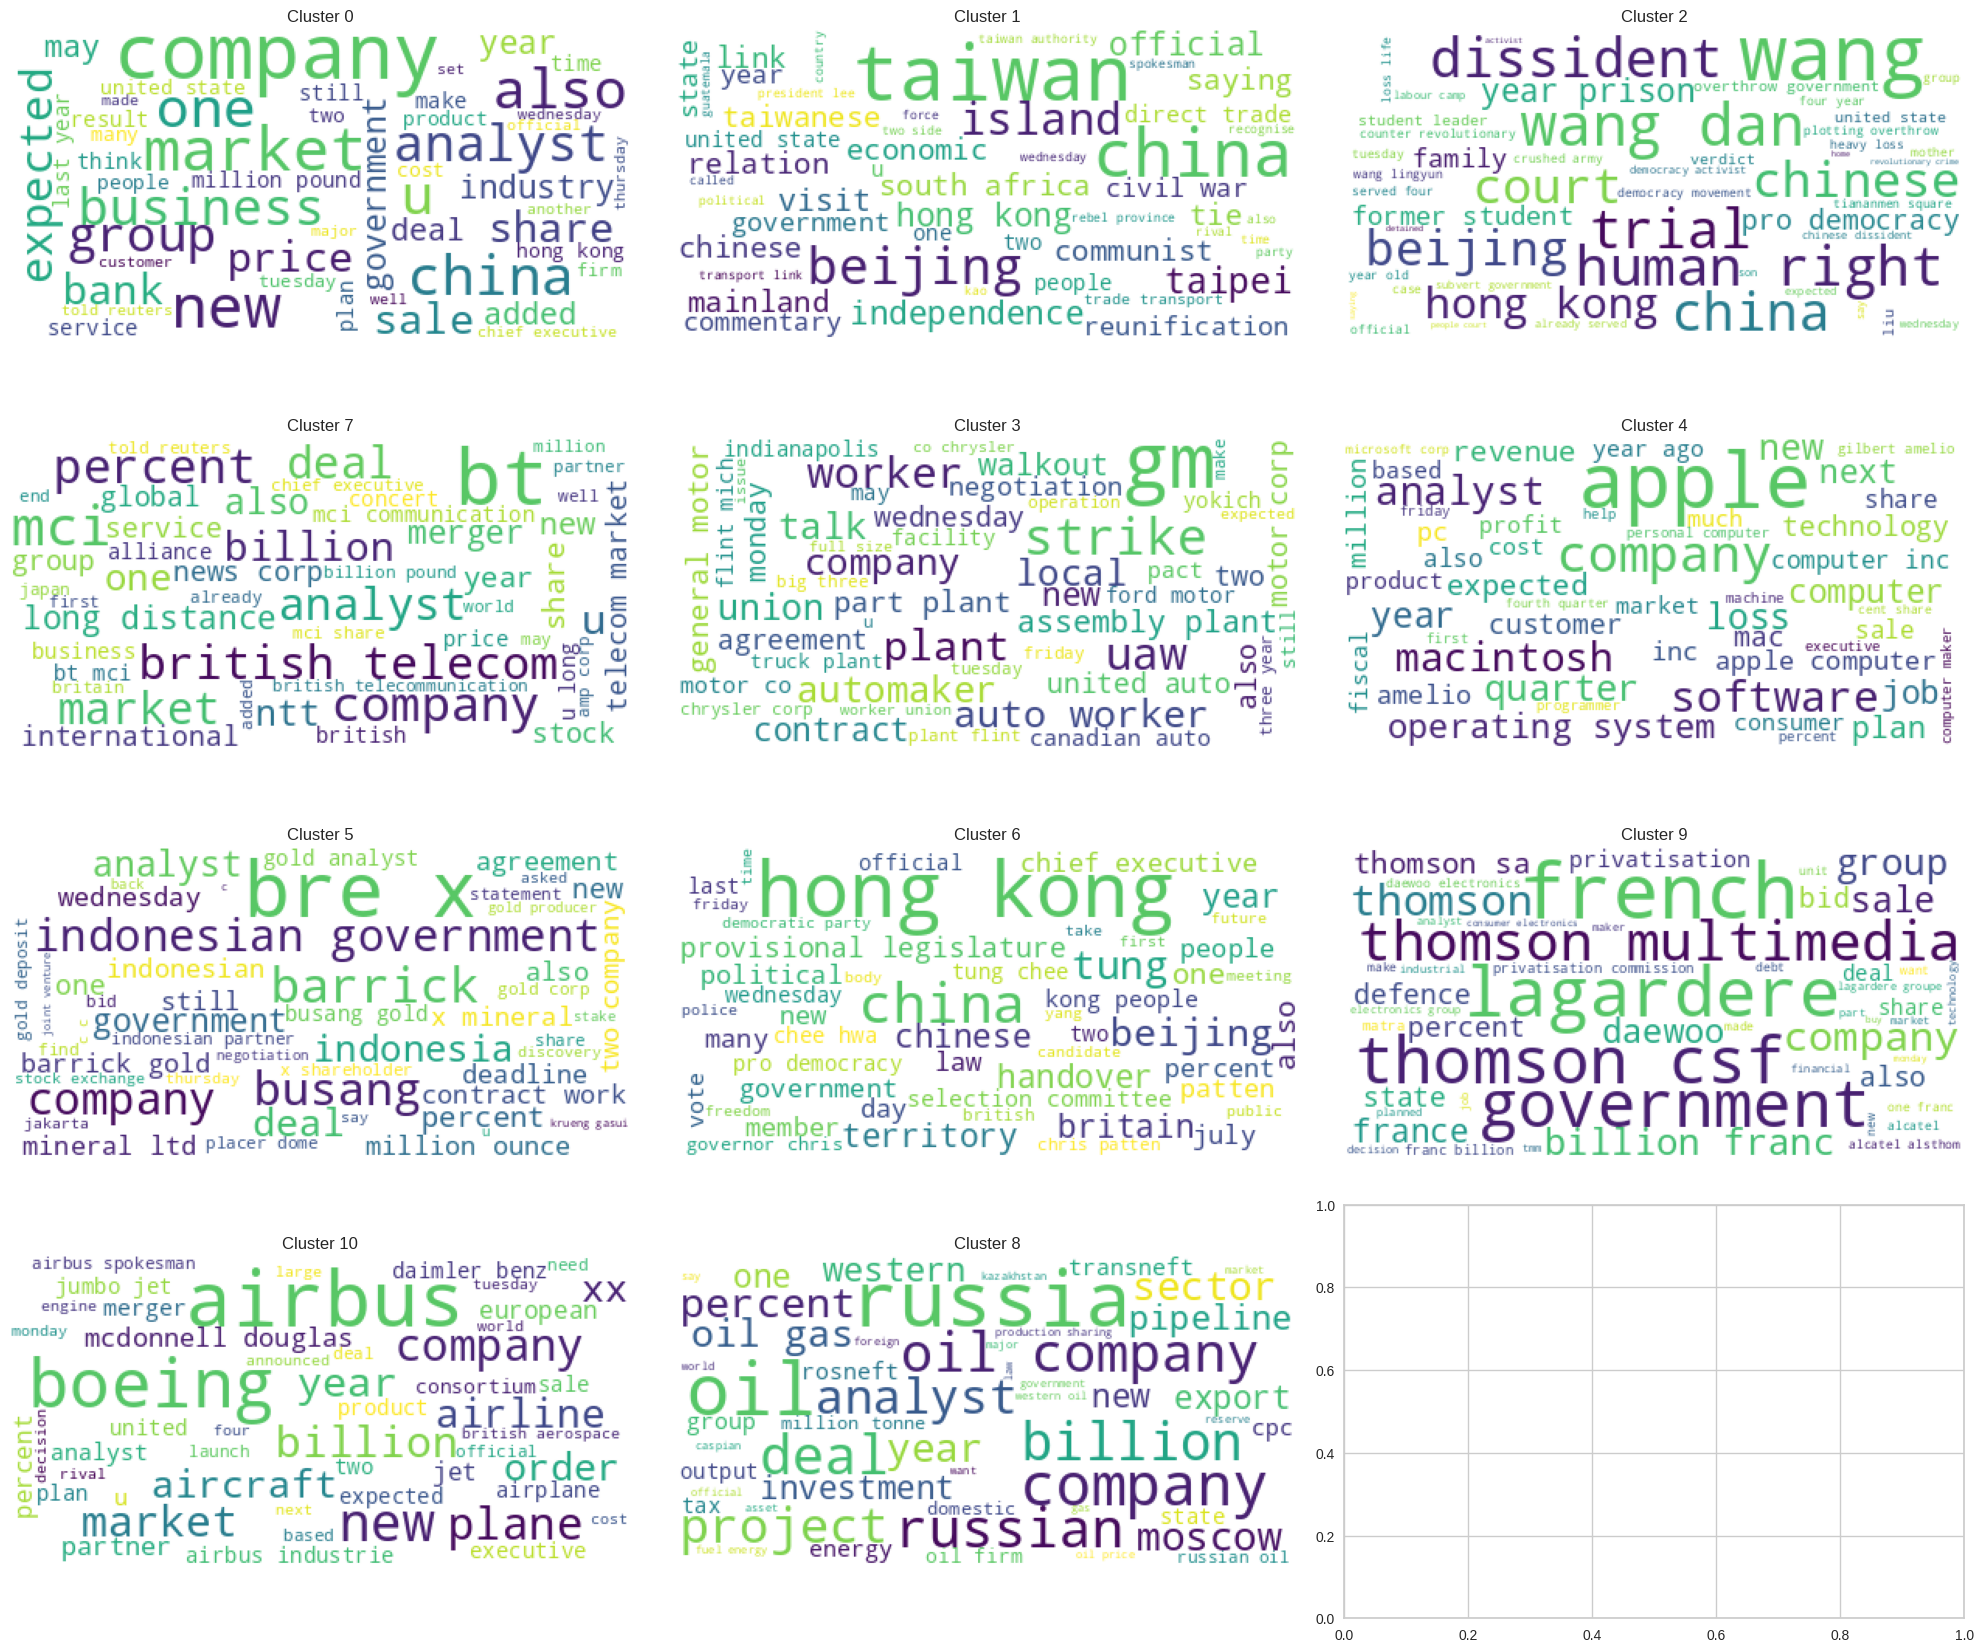

In [52]:
from wordcloud import WordCloud
import math

# This will contain all articles per cluster
articles_per_cluster = {label: '' for label in dbscan_labels}

# Collect all articles per cluster into our new dictionary
for label, article in zip(dbscan_labels, clean_articles_train):
    articles_per_cluster[label] += ' ' + article

cols = 3
rows = math.ceil(num_clusters / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20,17))

for i, (cluster, text) in enumerate(articles_per_cluster.items()):
    wordcloud = WordCloud(
        background_color ='white',
        stopwords = stopwords.words('english'),
        max_words=50,
        max_font_size=50,
        random_state=42
    ).generate(text)

    axs[i//cols, i%cols].imshow(wordcloud)
    axs[i//cols, i%cols].axis("off")
    axs[i//cols, i%cols].set_title(f'Cluster {cluster + 1}')

plt.tight_layout()
plt.show()

In [53]:
articles_per_cluster = {label: '' for label in dbscan_labels}

for label, article in zip(dbscan_labels, clean_articles_train):
    articles_per_cluster[label] += ' ' + article

sorted_items = sorted(articles_per_cluster.items())

for cluster, text in sorted_items:
    words = word_tokenize(text)
    common_words = Counter(words).most_common(5)  # get 10 most common words
    print(f'Cluster {cluster + 1} common words: {common_words}')

Cluster 0 common words: [('year', 6185), ('company', 4851), ('percent', 4719), ('million', 4649), ('market', 3824)]
Cluster 1 common words: [('taiwan', 248), ('china', 162), ('beijing', 84), ('island', 66), ('chinese', 50)]
Cluster 2 common words: [('wang', 446), ('year', 186), ('dissident', 160), ('court', 142), ('china', 132)]
Cluster 3 common words: [('gm', 693), ('plant', 490), ('worker', 356), ('uaw', 281), ('strike', 255)]
Cluster 4 common words: [('apple', 349), ('computer', 129), ('quarter', 111), ('company', 102), ('software', 101)]
Cluster 5 common words: [('bre', 328), ('x', 328), ('gold', 164), ('barrick', 152), ('busang', 133)]
Cluster 6 common words: [('hong', 1138), ('kong', 1130), ('china', 697), ('tung', 341), ('chinese', 275)]
Cluster 7 common words: [('bt', 424), ('mci', 417), ('market', 268), ('telecom', 253), ('company', 210)]
Cluster 8 common words: [('oil', 299), ('company', 111), ('russia', 110), ('russian', 64), ('energy', 55)]
Cluster 9 common words: [('thomso

### Results for Training Set
* **Cluster 1: Internet Software** - This cluster focuses on internet-based software and technology companies, indicated by common terms like "internet," "computer," "software," and "company."
* **Cluster 2: Corporate Sales & Analytics** - The conversation in this cluster revolves around corporate quarter results, yearly sales, and analysis, highlighted by frequent terms like "quarter," "analyst," and "sale."
* **Cluster 3: Hong Kong & China Relations** - The articles in this cluster likely focus on Hong Kong-China relations, as suggested by common terms like "hong", "kong", "china," and "tung."
* **Cluster 4: Gold & Stock Market** - This cluster is centered on the gold market and associated stocks, inferred from terms like "gold," "stock," "share," and "market."
* **Cluster 5: Telecommunications** - This cluster seems to concentrate on the telecommunications industry, signified by words like "mci," "bt," "amp," and "company."
* **Cluster 6: China's Economy** - This cluster possibly discusses China's economic affairs, with common words like "china," "chinese," "beijing," and "year."
* **Cluster 7: Banking Industry** - The discussion in this cluster centers around banking, witnessed from words like "bank," "banking," and "analyst."
* **Cluster 8: Automotive Industry** - A focus on automotive industry, specifically union activities and plant operations, is evidenced by terms like "gm," "plant," "worker," and "strike."
* **Cluster 9: Corporate Market Trends** - This cluster is likely concerned with market trends and developments in various companies, marked by words like "year," "market," "company," and "new."
* **Cluster 10: Financial Performance of Companies** - The conversation in this cluster revolves around company's financial performance with terms such as "million," "company," "year," "percent," and "share" being prominent.

### Conclusion
To sum up, we categorized the dataset into 10 unique clusters that represented various themes in the articles, such as financial performance, Chinese relations, and technology.

Dimensionality reduction with PCA and t-SNE allowed us to visualize these clusters. Although most clusters in t-SNE showed clear distinction in the plots, some displayed a bit of overlap or scattering, highlighting the dataset's inherent intricacy.

In essence, our analysis successfully divided the 2500 articles into 10 groups, revealing a wide array of topics. The blending of clustering and visualization methods offered key insights into the hidden patterns and relationships among the articles.

Our initial approach on the Reuters C50 dataset was to leverage clustering, however given the algorithm's in-built limitations, including the "curse of dimensionality" and lack of context when categorizing, applying KMeans/DBSCAN to such a high-dimensional text dataset generated less than ideal results.

To overcome those constraints, we transitioned to a topic modelling approach. Unlike clustering, topic modelling algorithms, such as Latent Dirichlet Allocation (LDA), are specifically built for text data. They create clusters based on topic distributions across documents, providing higher interpretability.

## Topic Modelling LDA
### Question for LDA:

1. What are the prominent topics across the articles in the dataset and can we distribute these topics appropriately?

#### Approach for LDA:

1. Preprocess the text by removing stop words, punctuation, and perform lemmatization, which reduces words to their base or root form.

2. Convert the collection of text documents (corpus) to a matrix of token counts using CountVectorizer, which is a better suited Vectorizer for LDA than TF-IDF.

3. Implement the Latent Dirichlet Allocation (LDA) model on the count vectorized matrix. The LDA model is used to categorize the articles into "topics".

4. Decide on the number of topics appropriate for the model. This can be done by using metrics like Perplexity and Coherence Score, or through human judgment of what constitutes a distinct topic.

5. Analyse the output of the LDA model by reviewing the words associated with each topic and deduce the theme.

6. Evaluate the results both qualitatively (reading through articles and making sure the topics make sense) and quantitatively (using perplexity and coherence score).

7. Visualize the topics for better interpretability using pyLDAvis.

#### Package Imports

In [60]:
!pip install --upgrade gensim pyLDAvis
!pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 28.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 r

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [62]:
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models import LdaModel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Analyses and Plots

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


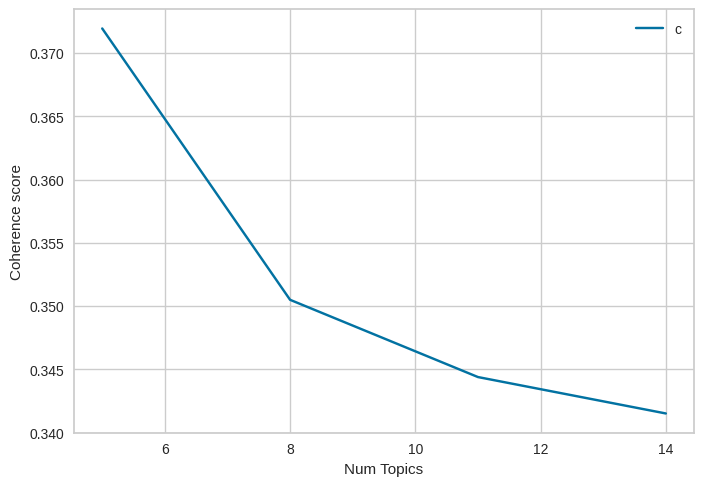

In [66]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Using cleaned pre-processed data
tokenized_articles = [article.split() for article in clean_articles_train]
dictionary = corpora.Dictionary(tokenized_articles)
corpus = [dictionary.doc2bow(article) for article in tokenized_articles]

start = 5
limit = 15
step = 3
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_articles, start=start, limit=limit, step=step)

# Show graph
import matplotlib.pyplot as plt
plt.plot(range(start, limit, step), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [64]:
# Chose 10 topics for ease of interpretability and similarity to K-Means clusters
lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

for idx in range(10):
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #0: 0.016*"kong" + 0.013*"hong" + 0.011*"china" + 0.007*"year" + 0.006*"fund" + 0.005*"one" + 0.005*"company" + 0.004*"government" + 0.004*"law" + 0.004*"people"
Topic #1: 0.010*"company" + 0.010*"market" + 0.010*"new" + 0.009*"analyst" + 0.008*"year" + 0.007*"corp" + 0.007*"percent" + 0.007*"service" + 0.005*"billion" + 0.005*"industry"
Topic #2: 0.016*"million" + 0.011*"percent" + 0.011*"year" + 0.010*"company" + 0.008*"sale" + 0.008*"profit" + 0.008*"gm" + 0.006*"pound" + 0.006*"analyst" + 0.006*"plant"
Topic #3: 0.008*"gm" + 0.008*"plant" + 0.007*"year" + 0.006*"worker" + 0.005*"new" + 0.005*"ford" + 0.005*"two" + 0.004*"hong" + 0.004*"company" + 0.004*"one"
Topic #4: 0.012*"year" + 0.008*"company" + 0.008*"percent" + 0.007*"billion" + 0.007*"china" + 0.006*"trade" + 0.006*"u" + 0.004*"foreign" + 0.004*"first" + 0.004*"hong"
Topic #5: 0.014*"china" + 0.012*"u" + 0.011*"percent" + 0.010*"year" + 0.008*"state" + 0.007*"million" + 0.006*"beijing" + 0.006*"company" + 0.005*"marke

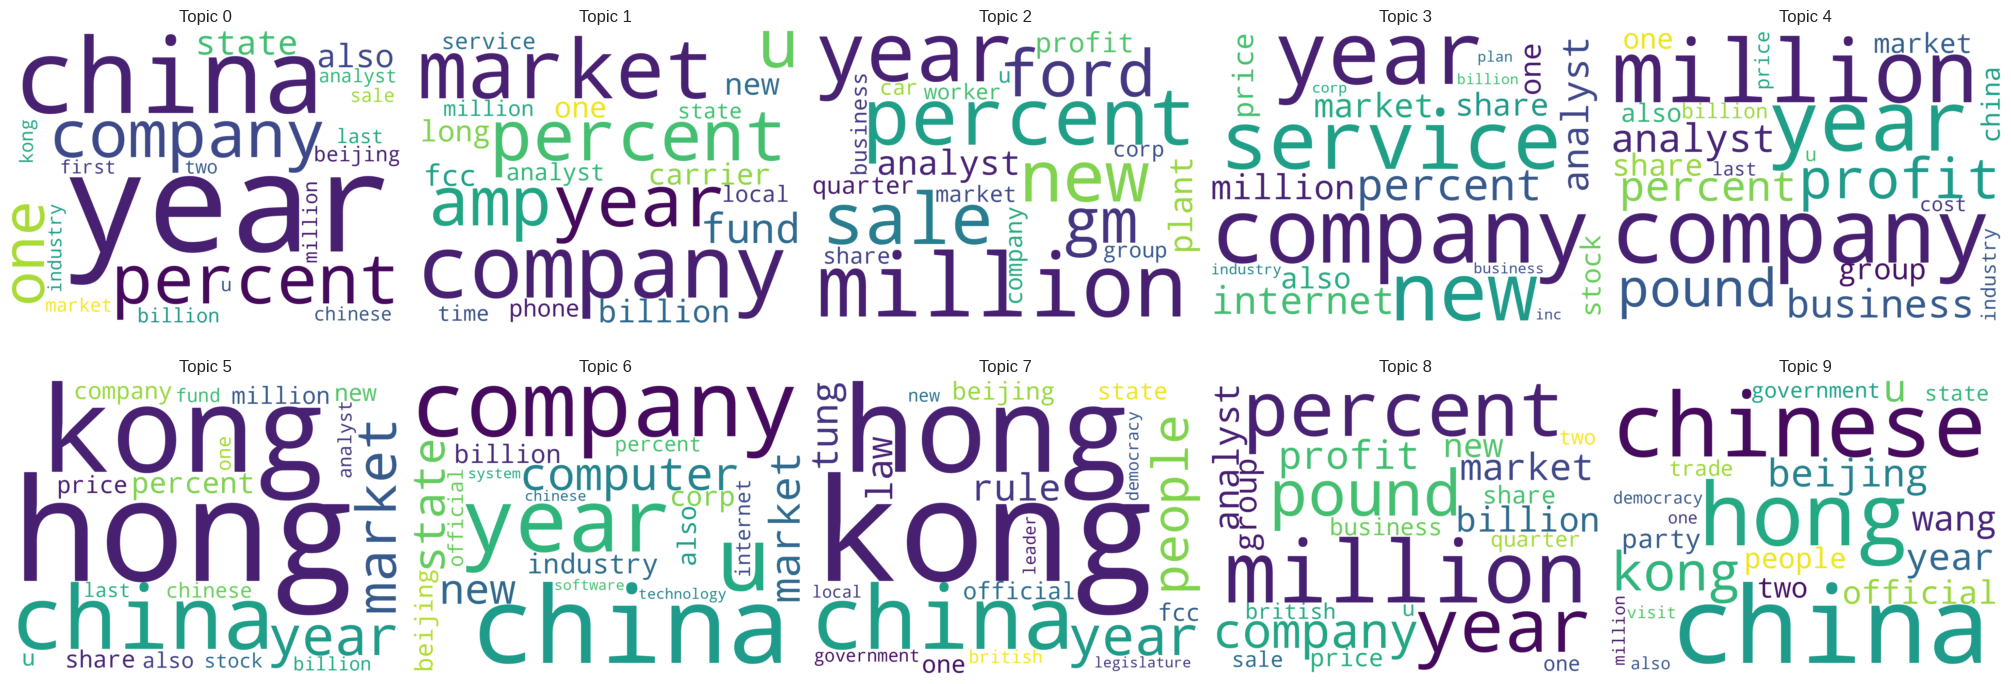

In [58]:
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud

fig = plt.figure(constrained_layout=True, figsize=(20,7))
spec = gridspec.GridSpec(ncols=5, nrows=2, figure=fig)

for idx, topic in lda_model.show_topics(formatted=False, num_words= 20):
    wc = WordCloud(
        background_color='white',
        max_words=20,
        width=400,
        height=300,
        scale=3,
        random_state=42
    )

    wordcloud = wc.generate_from_frequencies(dict(topic))

    ax = fig.add_subplot(spec[idx//5, idx%5])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title('Topic '+str(idx))

plt.show()

In [61]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds='mmds', R=30)
vis

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.030017  0.028986       1        1  14.960041
4     -0.071439 -0.008374       2        1  13.159661
1     -0.054440  0.054759       3        1  12.603766
6      0.010625  0.071213       4        1  11.595169
2     -0.085898 -0.084198       5        1  11.229778
8     -0.042840 -0.031043       6        1   9.180869
0      0.026442  0.008105       7        1   8.500785
5      0.023122 -0.035661       8        1   7.455209
9      0.111435 -0.036801       9        1   6.261871
7      0.113011  0.033015      10        1   5.052850, topic_info=         Term         Freq        Total Category  logprob  loglift
4808     hong  2917.000000  2917.000000  Default  30.0000  30.0000
4811     kong  2846.000000  2846.000000  Default  29.0000  29.0000
5018    china  3989.000000  3989.000000  Default  28.0000  28.0000
5731  chinese  1687.000000  1687.000000  Default  27.0000  27.0000
73    million  5519.000000  5519.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
832     chief   116.351138  1144.002199  Topic10  -5.7502   0.6995
80        new   139.683241  3885.590380  Topic10  -5.5675  -0.3404
455       two   118.637519  2198.721053  Topic10  -5.7308   0.0657
173       day   107.864086   923.784751  Topic10  -5.8260   0.8376
342   company   106.386440  5937.127041  Topic10  -5.8398  -1.0367

[855 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
13900      1  0.136589   abbey
13900      2  0.174083   abbey
13900      3  0.661517   abbey
13900      4  0.016069   abbey
13900      5  0.002678   abbey
...      ...       ...     ...
13675      1  0.870182  zhuhai
13675      2  0.015266  zhuhai
13675      6  0.061065  zhuhai
13675      7  0.030533  zhuhai
13675      8  0.015266  zhuhai

[3467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 7, 3, 9, 1, 6, 10, 8])

### Results for Training Set

Examining the 10 topics and the words most strongly associated with them, we can interpret the topics as follows:

- Topic #0 seems to focus on yearly financials and Chinese companies.
- Topic #1 is more concentrated on market straits, funds, and business performance.
- Topic #2 highlights auto companies (Ford and GM being mentioned), sales, profits, and analysts.
- Topic #3 appears to revolve around new services, the internet, and market share.
- Topic #4 emphasizes profits, business groups, and analysts.
- Topic #5 heavily features Hong Kong, China, and market shares.
- Topic #6 pertains to tech companies, particularly in China and the United States.
- Topic #7 contains explicit mentions of Hong Kong, China, and political terms such as "rule" and "law" suggesting it may be discussing Chinese municipal politics.
- Topic #8 is centered around profits, markets and business evaluations.
- Topic #9 appears to discuss Chinese politics with mentions of Beijing, China, and individuals like Wang.

### Conclusion
The LDA topic modelling has provided an overview of the main themes across the article collection: finances, market statistics, car sales, new services, company profits, Hong Kong, China and its political state. This not only underscores how diverse the dataset is but also helps understand how different topics are potentially interwoven in the same dataset.

LDA also like our previous approach of KMeans clustering, has identified similar key topics across the dataset related to finance, technology, and international issues, specifically related to China and Hong Kong. The key terms are quite similar across methodologies, with words like "year", "company", "china", "percent", "new", "market" and more appearing frequently.

LDA topic modelling offers an effective way to understand and categorize the topics within the Reuters C50 dataset automatically. This method allows faster processing of large text corpuses, providing significant themes that could be further studied or used for automated sorting or tagging of articles.

While unsupervised Topic Modelling like LDA provides useful exploratory insights and context, it has limitations when specific, definitive predictions are needed. LDA doesn't use any kind of labels during the training process, which, while useful for uncovering hidden patterns, makes it less reliable for concrete predictions.

Thus, we decided to transition to a supervised learning approach. With labeled data available in the Reuters C50 dataset, where each document is associated with a specific author, supervised methods can utilize this information to make accurate predictions.

## Document Classification
### Question for Supervised Learning:

1. Can we accurately predict the author of an article using a supervised machine learning model trained on stylistic features of their previous writings?
2. What is the accuracy of the predictions?

#### Approach for Supervised Learning:

1. Begin with loading the dataset such that each article is linked with its respective author for both the train and test data.

2. Preprocess the corpus by removing stop words, punctuation, and carrying out lemmatization like earlier.

3. Convert the preprocessed text data into numerical vectors using TF-IDF vectorization.

4. Choose a suitable supervised machine learning model like Naive Bayes or Random Forest.

6. Train the machine learning model on the training dataset. Subsequently, use this model to make predictions on the test set.

7. Evaluate the model's performance using appropriate metrics such as accuracy, precision, recall, and F1-score. A confusion matrix can be helpful to identify the instances of true positives, true negatives, false positives and false negatives.

8. Fine-tune the model via hyperparameter optimization if needed, aiming to improve its performance.

#### Package Imports

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load Test Data

In [67]:
test_folder = '/content/drive/MyDrive/Colab Notebooks/ML/C50test'

C50Test_corpus = {}
for subfolder in os.listdir(test_folder):
    subfolder_path = os.path.join(test_folder, subfolder)
    if os.path.isdir(subfolder_path):
        file_contents = []
        for filename in os.listdir(subfolder_path):
            if filename.endswith('.txt'):
                file_path = os.path.join(subfolder_path, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    file_contents.append(file.read())
        C50Test_corpus[subfolder] = file_contents

all_articles_test = [article for articles in C50Test_corpus.values() for article in articles]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
# Removing the words "said", "could", and "would" separately, as they aren't typically included in common stop words lists
words_to_remove = ["said", "could", "would"]
stop_words = set(stopwords.words('english')+words_to_remove)
lemmatizer = WordNetLemmatizer()

# Using the same clean_text function from K-Means
def clean_text(article):
    formatted_article = re.sub('[^a-zA-Z]', ' ', article )
    formatted_article = re.sub(r'\s+', ' ', formatted_article)

    word_list = word_tokenize(formatted_article.lower())
    word_list = [word for word in word_list if not word in stop_words]

    word_list = [lemmatizer.lemmatize(word) for word in word_list]

    return ' '.join(word_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
clean_articles_test = []
for article in all_articles_test:
  clean_articles_test.append(clean_text(article))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
all_articles_test[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'U.S. Senators on Tuesday sharply criticized a new Securities and Exchange Commission rule forcing companies to disclose their use of derivatives.\nBoth the SEC and the Financial Accounting Standards Board have issued proposals to make companies disclose more about derivatives use following some high-profile losses on the complex instruments in 1994.  \nDerivatives, financial instruments such as options and futures whose value is based on an underlying stock or commodity price, were involved in the bankruptcy of Orange County, Calif., and losses exceeding $100 million at Procter &amp; Gamble Co.\nThe SEC adopted its rules last month, while the FASB is still working on its proposal.\nOn Capitol Hill on Tuesday, senators took aim at both approaches, charging that the added expenses and complications would discourage companies from properly using derivatives to reduce risk.  \n"One of my chief concerns when I came to the Senate in 1993 was whether we had too many unnecessary rules and reg

In [71]:
clean_articles_test[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'u senator tuesday sharply criticized new security exchange commission rule forcing company disclose use derivative sec financial accounting standard board issued proposal make company disclose derivative use following high profile loss complex instrument derivative financial instrument option future whose value based underlying stock commodity price involved bankruptcy orange county calif loss exceeding million procter amp gamble co sec adopted rule last month fasb still working proposal capitol hill tuesday senator took aim approach charging added expense complication discourage company properly using derivative reduce risk one chief concern came senate whether many unnecessary rule regulation north carolina republican sen lauch faircloth hearing senate banking committee security subcommittee concerned may case sec new rule juncture agree direction heading faircloth added fasb private organization make accounting standard sec must approve rule make binding public company senator ques

### Naive-Bayes

In [75]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Vectorize the articles
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,1),
    max_features=500
)
X_train = vectorizer.fit_transform(clean_articles_train)
X_test = vectorizer.transform(clean_articles_test)

# Get the labels for training and test datasets
labels_train = [label for label, articles in C50Train_corpus.items() for article in articles]
labels_test = [label for label, articles in C50Test_corpus.items() for article in articles]

# Initialize a Naive Bayes classifier and fit on training data
model = MultinomialNB()
model.fit(X_train, labels_train)

# Make prediction and print the classification report
predictions = model.predict(X_test)
print(classification_report(labels_test, predictions))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                   precision    recall  f1-score   support

    AaronPressman       0.77      0.80      0.78        50
       AlanCrosby       0.87      0.54      0.67        50
   AlexanderSmith       0.62      0.42      0.50        50
  BenjaminKangLim       0.31      0.36      0.33        50
    BernardHickey       0.67      0.52      0.58        50
      BradDorfman       0.63      0.64      0.63        50
 DarrenSchuettler       0.37      0.26      0.31        50
      DavidLawder       0.31      0.28      0.29        50
    EdnaFernandes       0.67      0.28      0.39        50
      EricAuchard       0.47      0.28      0.35        50
   FumikoFujisaki       0.70      0.98      0.82        50
   GrahamEarnshaw       0.71      0.92      0.80        50
 HeatherScoffield       0.30      0.34      0.32        50
       JanLopatka       0.63      0.58      0.60        50
    JaneMacartney       0.30      0.30      0.30        50
     JimGilchrist       0.79      1.00      0.88       

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


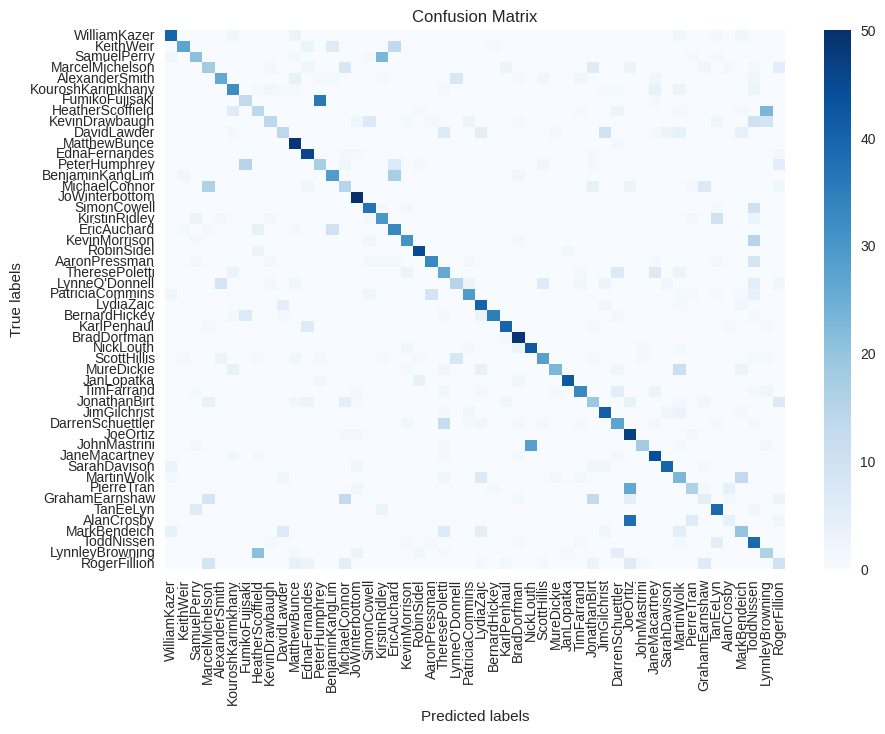

In [83]:
cm = confusion_matrix(labels_test, predictions)
labels = list(set(labels_test))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Random Forest Grid Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Vectorize the articles
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,1),
    max_features=500
)
X_train = vectorizer.fit_transform(clean_articles_train)
X_test = vectorizer.transform(clean_articles_test)

# Get the labels for training and test datasets
labels_train = [label for label, articles in C50Train_corpus.items() for article in articles]
labels_test = [label for label, articles in C50Test_corpus.items() for article in articles]

# Initialize parameters for Random Forest, you can customize as per your needs
parameters = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(RandomForestClassifier(), parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, labels_train)

# Get the best parameters
print("Best Parameters: ", grid_search.best_params_)
# n_estimators 500 - max_depth None - min_samples_split 5

In [86]:
# Use the model with best parameters to make prediction and print the classification report
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
)
model.fit(X_train, labels_train)

predictions = model.predict(X_test)
print(classification_report(labels_test, predictions))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                   precision    recall  f1-score   support

    AaronPressman       0.74      0.92      0.82        50
       AlanCrosby       0.90      0.52      0.66        50
   AlexanderSmith       0.67      0.32      0.43        50
  BenjaminKangLim       0.27      0.42      0.33        50
    BernardHickey       0.73      0.48      0.58        50
      BradDorfman       0.59      0.66      0.62        50
 DarrenSchuettler       0.24      0.26      0.25        50
      DavidLawder       0.50      0.18      0.26        50
    EdnaFernandes       0.67      0.32      0.43        50
      EricAuchard       0.48      0.24      0.32        50
   FumikoFujisaki       0.82      1.00      0.90        50
   GrahamEarnshaw       0.71      0.96      0.81        50
 HeatherScoffield       0.30      0.38      0.34        50
       JanLopatka       0.71      0.58      0.64        50
    JaneMacartney       0.24      0.16      0.19        50
     JimGilchrist       0.86      1.00      0.93       

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


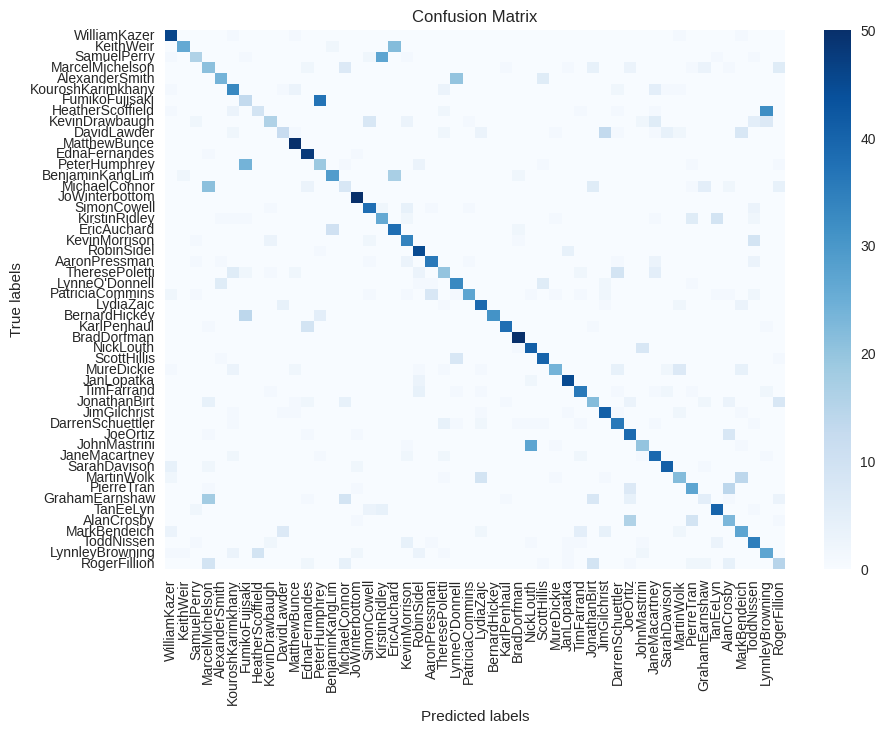

In [87]:
cm = confusion_matrix(labels_test, predictions)
labels = list(set(labels_test))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Results
The NLP analysis conducted on the Reuters C50 dataset started with a Naive Bayes Classsifier which resulted in a modest classification accuracy of 58%. In an attempt to improve this, we asopted a Random Forest Classifier model which resulted in a comparatively better 61% accuracy.

### Conclusion
Predicting author labels for the document proved challenging, resulting in fairly average accuracy. The Random Forest model, while effective, might be limited by the extensive dataset consisting of articles from various authors. Using advanced techniques like Neural Networks might yield better results in this context. With an accuracy of 61%, our RandomForest model managed to classify the entries reasonably well.